<div style="text-align: center; margin: 30px 0;">
  <span style="
    font-family: 'Playfair Display', serif;
    background-color:rgb(242, 64, 10);
    color: white;
    font-size: 1.5em;
    font-weight: 600;
    font-style: italic;
    padding: 12px 24px;
    border-radius: 12px;
    display: inline-block;
    box-shadow: 0 4px 12px rgba(18, 17, 17, 0.15);
    transition: transform 0.2s ease, box-shadow 0.2s ease;
    cursor: default;
  " 
  onmouseover="this.style.transform='scale(1.03)'; this.style.boxShadow='0 6px 16px rgba(0,0,0,0.2)'"
  onmouseout="this.style.transform='scale(1)'; this.style.boxShadow='0 4px 12px rgba(0,0,0,0.15)'"
  >
  Model Selection & Evaluation
  </span>
</div>
<a id="import-data"></a>


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,StratifiedKFold ,GridSearchCV
from sklearn.preprocessing import StandardScaler , RobustScaler ,MinMaxScaler 
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, average_precision_score,
    accuracy_score, log_loss, matthews_corrcoef,
    confusion_matrix, roc_curve, precision_recall_curve
)

from sklearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")


# Import Dataset

In [39]:
# Before feature extraction
df = pd.read_csv(r"../data/cleaned_train.csv")
X_train = df.drop("Class", axis=1)
y_train = df["Class"]


In [40]:
# After feature extraction
# df_eda = pd.read_csv(r'../data/df_eda.csv')
# x=df_eda.drop('Class',axis=1)
# y=df_eda['Class']

In [41]:
# validation dataset
df_val= pd.read_csv(r'../data/split/val.csv')
X_val=df_val.drop('Class',axis=1)
y_val=df_val['Class']

#  Optimal Threshold

In [42]:

def find_optimal_threshold(model, X_val, y_val, metric='f1'):
    """Find optimal threshold for binary classification using sklearn."""
    
    
    if not hasattr(model, 'predict_proba'):
        return 0.5
    
    y_probs = model.predict_proba(X_val)[:, 1]
    

    _, _, thresholds = precision_recall_curve(y_val, y_probs)
    
    best_score = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        
        if len(np.unique(y_pred)) == 1: 
            continue
            
        if metric == 'f1':
            score = f1_score(y_val, y_pred, zero_division=0)
        else:  # balanced_accuracy
            score = balanced_accuracy_score(y_val, y_pred)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold

# Evaluation Function 

In [43]:
def evaluate_binary_model(model, X, y, threshold=0.5):
    """Extended evaluation for binary imbalanced datasets"""
    probs = model.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    return {
        'accuracy': accuracy_score(y, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y, probs),
        'pr_auc': average_precision_score(y, probs),
        'log_loss': log_loss(y, probs),
        'mcc': matthews_corrcoef(y, y_pred),
        'specificity': tn / (tn + fp + 1e-8),
        'npv': tn / (tn + fn + 1e-8)
    }


# Visualization Function

In [44]:
def plot_binary_model_curves(model, X, y, threshold=0.5, title_prefix="Model"):
    """Plot ROC curve, PR curve, and Confusion Matrix for binary classification"""
    probs = model.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, probs)
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"{title_prefix} - ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, probs)
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, label="PR Curve", color="orange")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} - Precision-Recall Curve")
    plt.legend()

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} - Confusion Matrix")

    plt.tight_layout()
    plt.show()


# Hyperparameters

In [45]:

models = {
    'LogisticRegression': (
        LogisticRegression(
            class_weight='balanced',
            random_state=42,
        ),
        {
            # 'C': [0.1, 1.0, 10.0]
        },
        True
    ),
    
    'RandomForest': (
        RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            n_estimators=300,
        ),
        {
        },
        True
    ),
    'XGBoost': (
        XGBClassifier(
            scale_pos_weight=10,  
            random_state=42,
            eval_metric='logloss',
            n_estimators=300,
            max_depth =6,
            learning_rate = 0.2,

        ),
        {

        },
        True
    ) ,
        'Voting': (
        VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(class_weight='balanced', random_state=42,)),
                ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
                ('xgb', XGBClassifier(scale_pos_weight=10, random_state=42, eval_metric='logloss'))
            ],
            voting='soft'
        ),
        {},
        False
    )
    }

#  Training models without over_sampling

Training LogisticRegression...


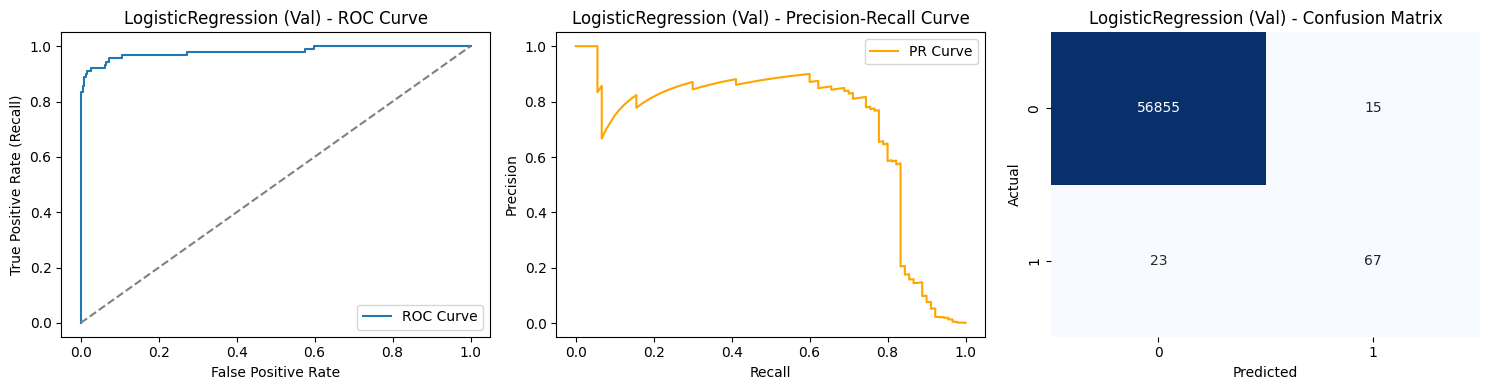

Training RandomForest...


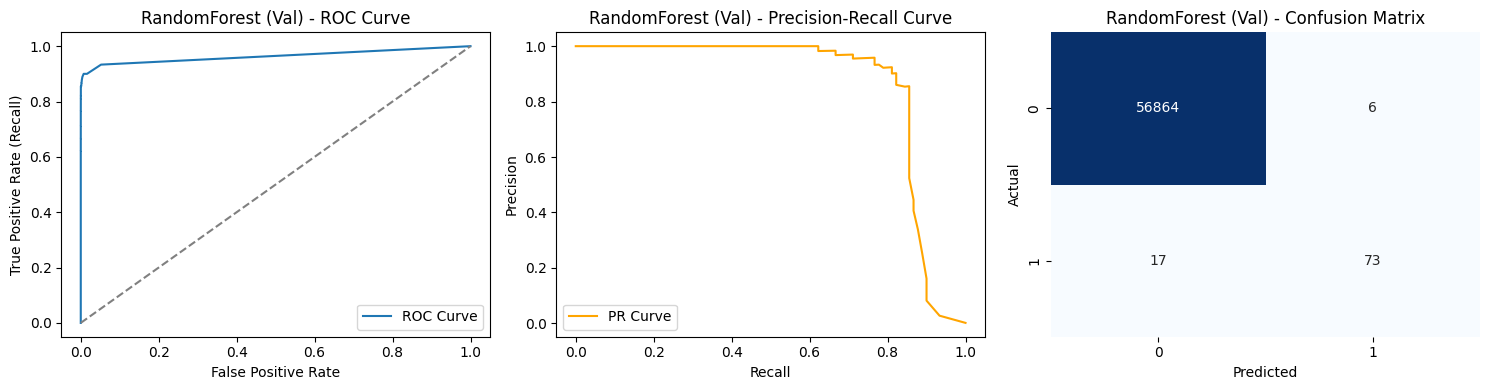

Training XGBoost...


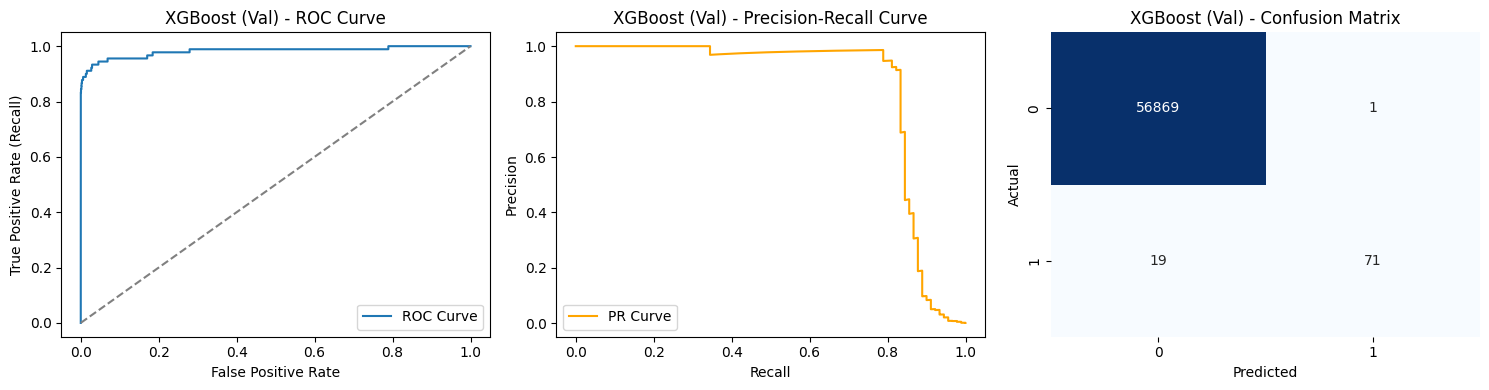

Training Voting...


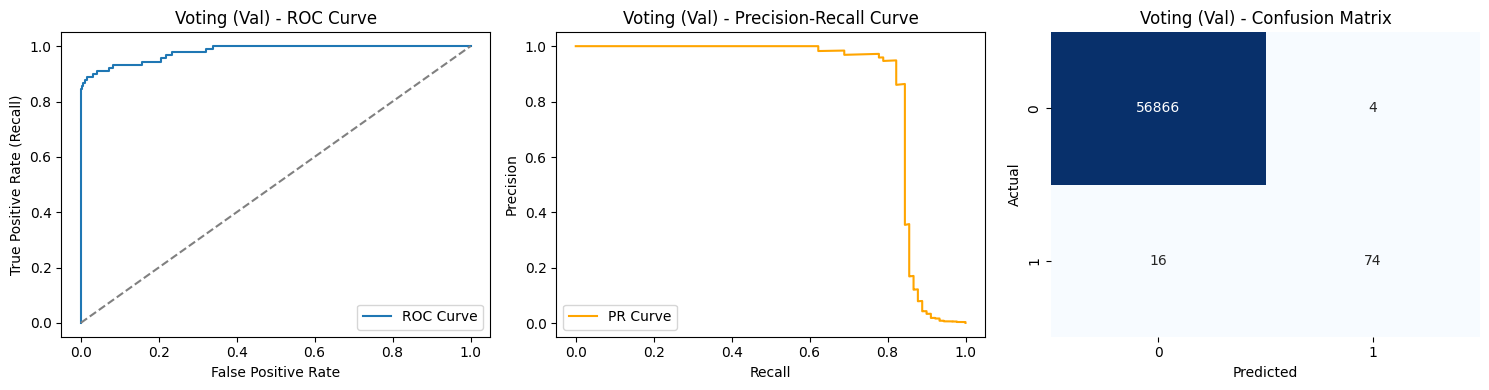


Results:
Set                  Train     Val
Model                             
LogisticRegression  0.7621  0.7791
RandomForest        0.9917  0.8639
Voting              1.0000  0.8810
XGBoost             1.0000  0.8765

Best model: Voting

Best Parameters per Model:
                Model Best_Params
0  LogisticRegression          {}
1        RandomForest          {}
2             XGBoost          {}
3              Voting          {}


In [46]:

best_models = {}
results = []
best_params_list = []  

# Faster Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, (model, params, scale) in models.items():
    print(f"Training {name}...")

    try:
        # Align features if DataFrame
        if hasattr(X_train, 'columns') and hasattr(X_val, 'columns'):
            common_cols = X_train.columns.intersection(X_val.columns)
            X_train_aligned = X_train[common_cols]
            X_val_aligned = X_val[common_cols]
        else:
            X_train_aligned, X_val_aligned = X_train, X_val

        # ===== Build pipeline (RobustScaler -> MinMaxScaler -> Model) =====
        if scale:
            pipe = Pipeline([
                ("robust", RobustScaler()),
                ("minmax", MinMaxScaler()),
                ("model", model)
            ])
        else:
            pipe = Pipeline([
                ("model", model)
            ])

        # Hyperparameter tuning
        if params:
            # Important: prefix params with "model__"
            param_grid = {f"model__{k}": v for k, v in params.items()}

            grid = GridSearchCV(
                pipe, param_grid, cv=cv,
                scoring="f1", n_jobs=-1, verbose=0
            )
            grid.fit(X_train_aligned, y_train)
            best_model = grid.best_estimator_

            # Save best parameters
            best_params_list.append({
                "Model": name,
                "Best_Params": grid.best_params_
            })

        else:
            best_model = pipe
            best_model.fit(X_train_aligned, y_train)

            best_params_list.append({
                "Model": name,
                "Best_Params": {}
            })

        best_models[name] = best_model

        # Find optimal threshold (assume function exists)
        threshold = find_optimal_threshold(best_model, X_val_aligned, y_val)

        # Evaluate + Visualize
        for set_name, X_set, y_set in [
            ("Train", X_train_aligned, y_train),
            ("Val", X_val_aligned, y_val)
        ]:
            metrics = evaluate_binary_model(best_model, X_set, y_set, threshold)
            results.append({
                "Model": name,
                "Set": set_name,
                "Threshold": threshold,
                **metrics
            })

            # Visualization for Validation set only
            if set_name == "Val":
                plot_binary_model_curves(best_model, X_set, y_set, threshold, title_prefix=f"{name} ({set_name})")

    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# ===== Results =====
results_df = pd.DataFrame(results)
if not results_df.empty:
    print("\nResults:")
    print(results_df.pivot(index="Model", columns="Set", values="f1_score").round(4))

    val_results = results_df[results_df["Set"] == "Val"]
    if not val_results.empty:
        best_model_name = val_results.loc[val_results["f1_score"].idxmax(), "Model"]
        print(f"\nBest model: {best_model_name}")
else:
    print("No results generated.")

# ===== Best Parameters =====
if best_params_list:
    best_params_df = pd.DataFrame(best_params_list)
    print("\nBest Parameters per Model:")
    print(best_params_df)


In [47]:
results_df

,Model,Set,Threshold,accuracy,balanced_accuracy,f1_score,precision,recall,roc_auc,pr_auc,log_loss,mcc,specificity,npv
0,LogisticRegression,Train,0.996652,0.999190,0.871872,0.762069,0.780919,0.744108,0.984677,0.743239,0.117214,0.761886,0.999636,0.999553
1,LogisticRegression,Val,0.996652,0.999333,0.872090,0.779070,0.817073,0.744444,0.979363,0.712308,0.116779,0.779583,0.999736,0.999596
2,RandomForest,Train,0.303333,0.999971,0.999985,0.991653,0.983444,1.000000,1.000000,1.000000,0.000399,0.991673,0.999971,1.000000
3,RandomForest,Val,0.303333,0.999596,0.905503,0.863905,0.924051,0.811111,0.963635,0.856156,0.005238,0.865545,0.999894,0.999701
4,XGBoost,Train,0.690069,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000018,1.000000,1.000000,1.000000
5,XGBoost,Val,0.690069,0.999649,0.894436,0.876543,0.986111,0.788889,0.981817,0.848112,0.002952,0.881845,0.999982,0.999666
6,Voting,Train,0.504680,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.044005,1.000000,1.000000,1.000000
7,Voting,Val,0.504680,0.999649,0.911076,0.880952,0.948718,0.822222,0.980646,0.845375,0.044994,0.883040,0.999930,0.999719


In [ ]:
results_df

# Training models with ( over_sampling ) 

In [51]:
# Before feature extraction
df = pd.read_csv(r"../data/cleaned_train.csv")
X_train = df.drop("Class", axis=1)
y_train = df["Class"]

In [52]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
             

Training LogisticRegression...


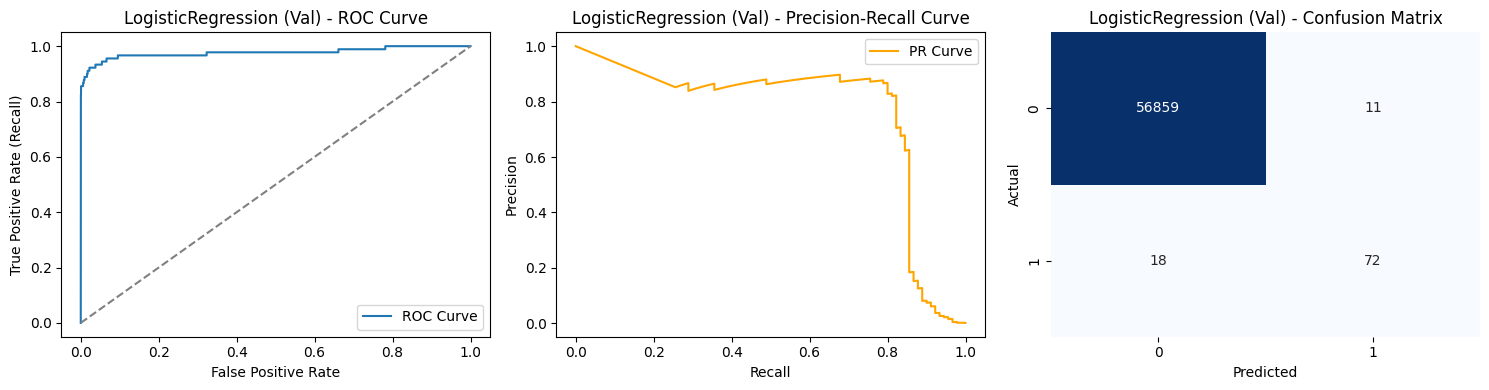

Training RandomForest...


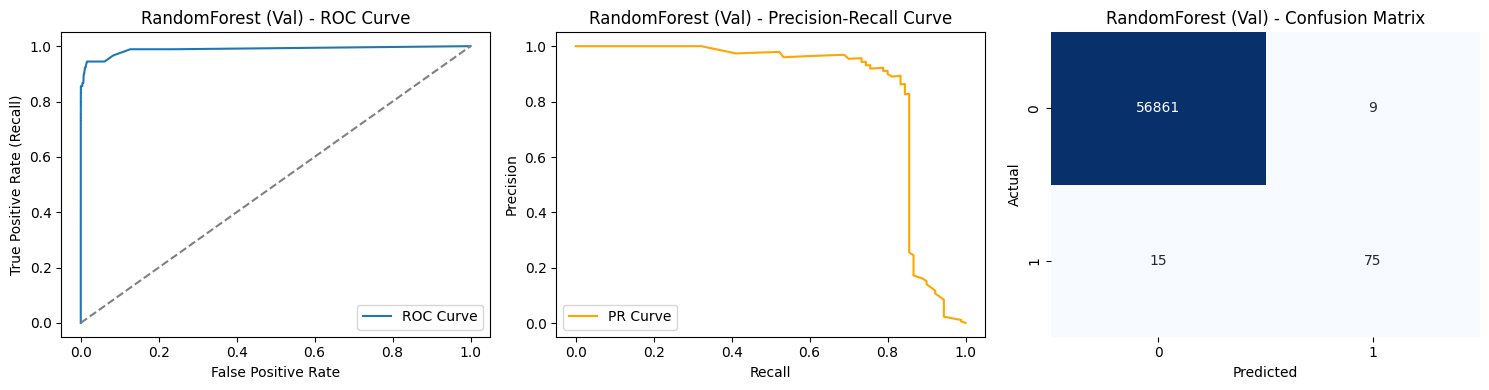

Training XGBoost...


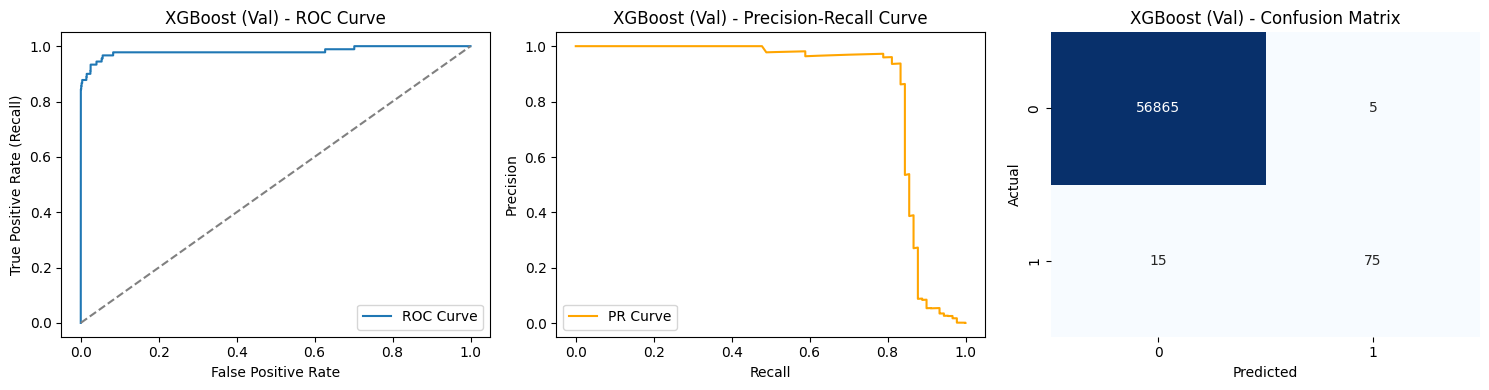

Training Voting...


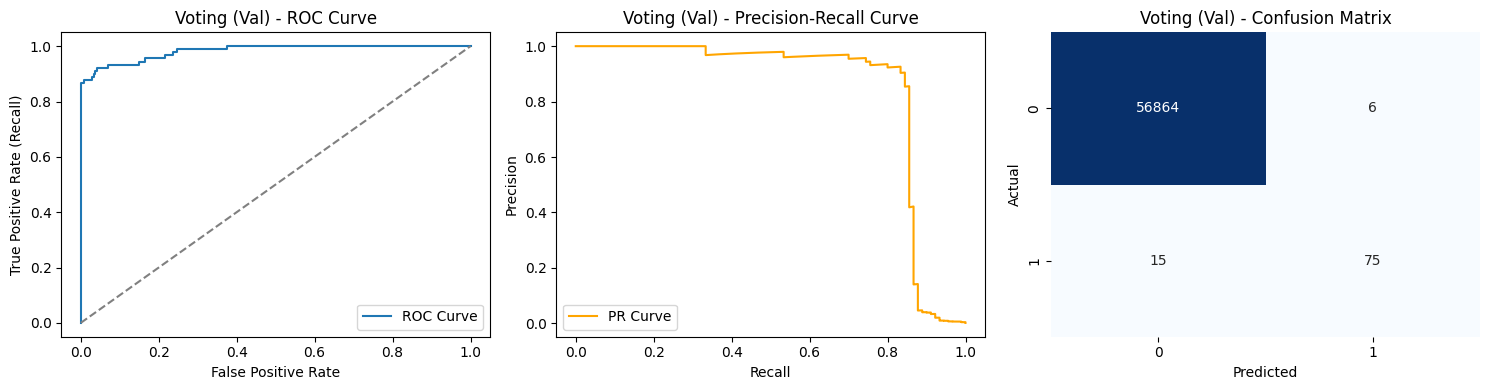


Results:
Set                  Train     Val
Model                             
LogisticRegression  0.9086  0.8324
RandomForest        1.0000  0.8621
Voting              0.9856  0.8772
XGBoost             1.0000  0.8824

Best model: XGBoost

Best Parameters per Model:
                Model Best_Params
0  LogisticRegression          {}
1        RandomForest          {}
2             XGBoost          {}
3              Voting          {}


In [53]:

best_models = {}
results = []
best_params_list = []  

# Faster Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, (model, params, scale) in models.items():
    print(f"Training {name}...")

    try:
        # Align features if DataFrame
        if hasattr(X_train, 'columns') and hasattr(X_val, 'columns'):
            common_cols = X_train.columns.intersection(X_val.columns)
            X_train_aligned = X_train[common_cols]
            X_val_aligned = X_val[common_cols]
        else:
            X_train_aligned, X_val_aligned = X_train, X_val

        # ===== Build pipeline (RobustScaler -> MinMaxScaler -> Model) =====
        if scale:
            pipe = Pipeline([
                ("robust", RobustScaler()),
                ("minmax", MinMaxScaler()),
                ("model", model)
            ])
        else:
            pipe = Pipeline([
                ("model", model)
            ])

        # Hyperparameter tuning
        if params:
            # Important: prefix params with "model__"
            param_grid = {f"model__{k}": v for k, v in params.items()}

            grid = GridSearchCV(
                pipe, param_grid, cv=cv,
                scoring="f1", n_jobs=-1, verbose=0
            )
            grid.fit(X_train_aligned, y_train)
            best_model = grid.best_estimator_

            # Save best parameters
            best_params_list.append({
                "Model": name,
                "Best_Params": grid.best_params_
            })

        else:
            best_model = pipe
            best_model.fit(X_train_aligned, y_train)

            best_params_list.append({
                "Model": name,
                "Best_Params": {}
            })

        best_models[name] = best_model

        # Find optimal threshold (assume function exists)
        threshold = find_optimal_threshold(best_model, X_val_aligned, y_val)

        # Evaluate + Visualize
        for set_name, X_set, y_set in [
            ("Train", X_train_aligned, y_train),
            ("Val", X_val_aligned, y_val)
        ]:
            metrics = evaluate_binary_model(best_model, X_set, y_set, threshold)
            results.append({
                "Model": name,
                "Set": set_name,
                "Threshold": threshold,
                **metrics
            })

            # Visualization for Validation set only
            if set_name == "Val":
                plot_binary_model_curves(best_model, X_set, y_set, threshold, title_prefix=f"{name} ({set_name})")

    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# ===== Results =====
results_df = pd.DataFrame(results)
if not results_df.empty:
    print("\nResults:")
    print(results_df.pivot(index="Model", columns="Set", values="f1_score").round(4))

    val_results = results_df[results_df["Set"] == "Val"]
    if not val_results.empty:
        best_model_name = val_results.loc[val_results["f1_score"].idxmax(), "Model"]
        print(f"\nBest model: {best_model_name}")
else:
    print("No results generated.")

# ===== Best Parameters =====
if best_params_list:
    best_params_df = pd.DataFrame(best_params_list)
    print("\nBest Parameters per Model:")
    print(best_params_df)


In [54]:
results_df

,Model,Set,Threshold,accuracy,balanced_accuracy,f1_score,precision,recall,roc_auc,pr_auc,log_loss,mcc,specificity,npv
0,LogisticRegression,Train,0.999591,0.916260,0.916260,0.908629,0.999725,0.832749,0.995607,0.996211,0.078394,0.844380,0.999771,0.856685
1,LogisticRegression,Val,0.999591,0.999491,0.899903,0.832370,0.867470,0.800000,0.976589,0.742100,0.062037,0.832799,0.999807,0.999684
2,RandomForest,Train,0.410000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000863,1.000000,1.000000,1.000000
3,RandomForest,Val,0.410000,0.999579,0.916588,0.862069,0.892857,0.833333,0.988339,0.844334,0.004821,0.862373,0.999842,0.999736
4,XGBoost,Train,0.872553,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000016,1.000000,1.000000,1.000000
5,XGBoost,Val,0.872553,0.999649,0.916623,0.882353,0.937500,0.833333,0.981387,0.850563,0.003391,0.883713,0.999912,0.999736
6,Voting,Train,0.761857,0.985823,0.985823,0.985619,1.000000,0.971647,1.000000,1.000000,0.019391,0.972038,1.000000,0.972428
7,Voting,Val,0.761857,0.999631,0.916614,0.877193,0.925926,0.833333,0.982084,0.842827,0.024792,0.878230,0.999894,0.999736
